In [ ]:
!pip uninstall opencv-python-headless opencv-python -y
!pip install opencv-contrib-python
#suchit

Found existing installation: opencv-python-headless 4.11.0.86
Uninstalling opencv-python-headless-4.11.0.86:
  Successfully uninstalled opencv-python-headless-4.11.0.86


In [ ]:
import os
os.kill(os.getpid(), 9)

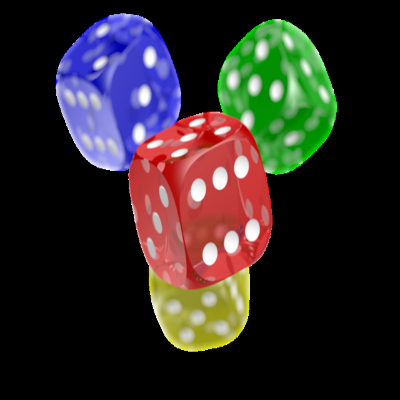

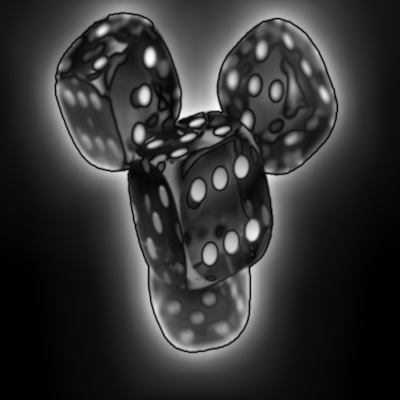

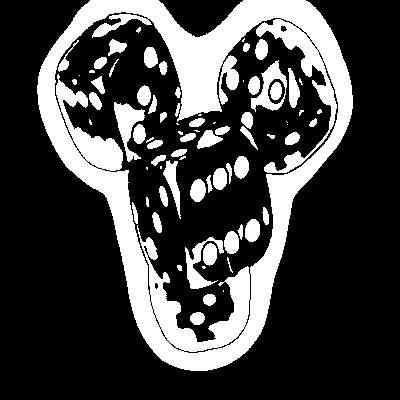

In [ ]:
!pip install opencv-contrib-python
import cv2
import numpy as np
import urllib.request
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow

url = 'https://upload.wikimedia.org/wikipedia/commons/thumb/4/47/PNG_transparency_demonstration_1.png/640px-PNG_transparency_demonstration_1.png'
urllib.request.urlretrieve(url, 'image.png')

image = cv2.imread('image.png')
image = cv2.resize(image, (400, 400))

saliency = cv2.saliency.StaticSaliencyFineGrained_create()
(success, saliency_map) = saliency.computeSaliency(image)

threshMap = cv2.threshold((saliency_map * 255).astype("uint8"), 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]

cv2_imshow(image)
cv2_imshow((saliency_map * 255).astype("uint8"))
cv2_imshow(threshMap)


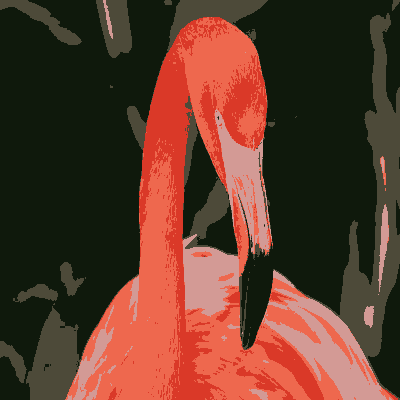

In [ ]:
import cv2
import numpy as np
import urllib.request
from google.colab.patches import cv2_imshow

url = 'https://upload.wikimedia.org/wikipedia/commons/thumb/f/f9/Phoenicopterus_ruber_in_S%C3%A3o_Paulo_Zoo.jpg/640px-Phoenicopterus_ruber_in_S%C3%A3o_Paulo_Zoo.jpg'
urllib.request.urlretrieve(url, 'landscape.jpg')

img = cv2.imread('landscape.jpg')
img = cv2.resize(img, (400, 400))

Z = img.reshape((-1, 3))
Z = np.float32(Z)

criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
K = 5
ret, label, center = cv2.kmeans(Z, K, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

center = np.uint8(center)
res = center[label.flatten()]
segmented_image = res.reshape((img.shape))

cv2_imshow(segmented_image)


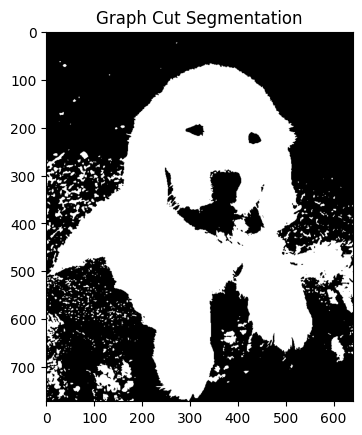

In [ ]:
import urllib.request

url = 'https://upload.wikimedia.org/wikipedia/commons/thumb/6/6e/Golde33443.jpg/640px-Golde33443.jpg'
urllib.request.urlretrieve(url, 'sample.jpg')
import os

os.listdir()

apply_graph_cut('sample.jpg')

In [1]:
!pip install -q imageio imageio-ffmpeg
!pip install -q git+https://github.com/bogireddytejareddy/gan-video-generation.git
!apt-get install unrar

import os
import random
import shutil
import cv2
import numpy as np
import imageio
from glob import glob
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from tqdm import tqdm

!wget --no-check-certificate http://crcv.ucf.edu/data/UCF101/UCF101.rar

!mkdir ucf101_videos
!unrar x UCF101.rar ucf101_videos/

print("✅ UCF101 dataset downloaded and extracted.")

selected_classes = ['JumpingJack', 'PushUps']
n_videos_per_class = 5
resize_height = 64
resize_width = 64
target_frames = 16

dataset_root = 'ucf101_videos/UCF-101'
processed_root = 'processed_videos'

os.makedirs(processed_root, exist_ok=True)

for cls in selected_classes:
    class_path = os.path.join(dataset_root, cls)
    save_class_path = os.path.join(processed_root, cls)
    os.makedirs(save_class_path, exist_ok=True)

    videos = glob(os.path.join(class_path, '*.avi'))
    selected_videos = random.sample(videos, n_videos_per_class)

    for idx, video_path in enumerate(selected_videos):
        cap = cv2.VideoCapture(video_path)
        frames = []

        while True:
            ret, frame = cap.read()
            if not ret:
                break
            frame = cv2.resize(frame, (resize_width, resize_height))
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frames.append(frame)
        cap.release()

        if len(frames) >= target_frames:
            frames = frames[:target_frames]
        else:
            frames = frames + [frames[-1]] * (target_frames - len(frames))

        frames = np.array(frames)
        np.save(os.path.join(save_class_path, f'{cls}_{idx}.npy'), frames)

print("✅ Videos processed and saved.")

Streaming output truncated to the last 5000 lines.
Extracting  ucf101_videos/UCF-101/PlayingGuitar/v_PlayingGuitar_g06_c07.avi      62%  OK 
Extracting  ucf101_videos/UCF-101/PlayingGuitar/v_PlayingGuitar_g07_c01.avi      62%  OK 
Extracting  ucf101_videos/UCF-101/PlayingGuitar/v_PlayingGuitar_g07_c02.avi      62%  OK 
Extracting  ucf101_videos/UCF-101/PlayingGuitar/v_PlayingGuitar_g07_c03.avi      62%  OK 
Extracting  ucf101_videos/UCF-101/PlayingGuitar/v_PlayingGuitar_g07_c04.avi      62%  OK 
Extracting  ucf101_videos/UCF-101/PlayingGuitar/v_PlayingGuitar_g07_c05.avi      62%  OK 
Extracting  ucf101_videos/UCF-101/PlayingGuitar/v_PlayingGuitar_g07_c06.avi      62%  OK 
Extracting  ucf101_videos/UCF-101/PlayingGuitar/v_PlayingGuitar_g07_c07.avi      62%  OK 
Extracting  ucf101_videos/UCF-101/PlayingGuitar/v_PlayingGuitar_g08_c01.avi      62%  OK 
Extracting  ucf101_videos/UCF-101/PlayingGuitar/v_PlayingG

In [6]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
from glob import glob
from tqdm import tqdm
import imageio

class VideoDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir, transform=None):
        self.files = []
        for cls in os.listdir(root_dir):
            cls_folder = os.path.join(root_dir, cls)
            self.files.extend(glob(os.path.join(cls_folder, '*.npy')))
        self.transform = transform

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        video = np.load(self.files[idx])
        video = video.astype(np.float32) / 127.5 - 1.0
        video = torch.from_numpy(video).permute(3, 0, 1, 2)
        return video

processed_root = '/content/processed_videos'
dataset = VideoDataset(processed_root)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc = nn.Linear(100, 512*2*4*4)
        self.deconv = nn.Sequential(
            nn.ConvTranspose3d(512, 256, (2,4,4), stride=(2,2,2), padding=(0,1,1)),
            nn.BatchNorm3d(256),
            nn.ReLU(True),
            nn.ConvTranspose3d(256, 128, (2,4,4), stride=(2,2,2), padding=(0,1,1)),
            nn.BatchNorm3d(128),
            nn.ReLU(True),
            nn.ConvTranspose3d(128, 3, (2,4,4), stride=(2,2,2), padding=(0,1,1)),
            nn.Tanh()
        )

    def forward(self, z):
        x = self.fc(z).view(-1, 512, 2, 4, 4)
        return self.deconv(x)

class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv3d(3, 64, 4, 2, 1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv3d(64, 128, 4, 2, 1),
            nn.BatchNorm3d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv3d(128, 256, 4, 2, 1),
            nn.BatchNorm3d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv3d(256, 1, (2,4,4), stride=1, padding=0),
        )

    def forward(self, x):
        return self.conv(x).view(x.size(0), -1)


G = Generator().to(device)
D = Discriminator().to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer_G = optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))

epochs = 50

for epoch in range(epochs):
    G.train()
    D.train()
    g_running_loss = 0.0
    d_running_loss = 0.0

    for real_videos in tqdm(dataloader):
        real_videos = real_videos.to(device)

        batch_size = real_videos.size(0)

        optimizer_G.zero_grad()
        z = torch.randn(batch_size, 100, device=device)
        fake_videos = G(z)

        pred_fake = D(fake_videos)
        valid = torch.ones_like(pred_fake, device=device)

        g_loss = criterion(pred_fake, valid)
        g_loss.backward()
        optimizer_G.step()

        optimizer_D.zero_grad()
        pred_real = D(real_videos)
        pred_fake = D(fake_videos.detach())

        valid = torch.ones_like(pred_real, device=device)
        fake = torch.zeros_like(pred_fake, device=device)

        real_loss = criterion(pred_real, valid)
        fake_loss = criterion(pred_fake, fake)
        d_loss = (real_loss + fake_loss) / 2

        d_loss.backward()
        optimizer_D.step()

        g_running_loss += g_loss.item()
        d_running_loss += d_loss.item()

    avg_g_loss = g_running_loss / len(dataloader)
    avg_d_loss = d_running_loss / len(dataloader)
    print(f"Epoch [{epoch+1}/{epochs}]  D_loss: {avg_d_loss:.4f}  G_loss: {avg_g_loss:.4f}")

G.eval()
z = torch.randn(1, 100, device=device)
fake_video = G(z).detach().cpu()
fake_video = (fake_video + 1) / 2
fake_video = fake_video.squeeze().permute(1, 2, 3, 0).numpy()

frames = [(frame*255).astype(np.uint8) for frame in fake_video]
imageio.mimsave('generated_video.gif', frames, fps=4)

print("✅ Generated video saved as 'generated_video.gif'.")

100%|██████████| 3/3 [00:03<00:00,  1.09s/it]


Epoch [1/50]  D_loss: 0.4155  G_loss: 2.0126


100%|██████████| 3/3 [00:02<00:00,  1.05it/s]


Epoch [2/50]  D_loss: 0.0915  G_loss: 2.6187


100%|██████████| 3/3 [00:02<00:00,  1.01it/s]


Epoch [3/50]  D_loss: 0.0473  G_loss: 3.3541


100%|██████████| 3/3 [00:03<00:00,  1.30s/it]


Epoch [4/50]  D_loss: 0.0205  G_loss: 5.9865


100%|██████████| 3/3 [00:02<00:00,  1.02it/s]


Epoch [5/50]  D_loss: 0.1439  G_loss: 8.2315


100%|██████████| 3/3 [00:02<00:00,  1.02it/s]


Epoch [6/50]  D_loss: 0.0211  G_loss: 12.2513


100%|██████████| 3/3 [00:02<00:00,  1.04it/s]


Epoch [7/50]  D_loss: 0.0811  G_loss: 4.6378


100%|██████████| 3/3 [00:03<00:00,  1.31s/it]


Epoch [8/50]  D_loss: 0.0415  G_loss: 12.6464


100%|██████████| 3/3 [00:02<00:00,  1.04it/s]


Epoch [9/50]  D_loss: 0.0125  G_loss: 10.7818


100%|██████████| 3/3 [00:02<00:00,  1.03it/s]


Epoch [10/50]  D_loss: 0.0358  G_loss: 5.3839


100%|██████████| 3/3 [00:02<00:00,  1.03it/s]


Epoch [11/50]  D_loss: 0.0127  G_loss: 8.0050


100%|██████████| 3/3 [00:03<00:00,  1.28s/it]


Epoch [12/50]  D_loss: 0.0334  G_loss: 7.3225


100%|██████████| 3/3 [00:02<00:00,  1.02it/s]


Epoch [13/50]  D_loss: 0.0083  G_loss: 8.2785


100%|██████████| 3/3 [00:02<00:00,  1.05it/s]


Epoch [14/50]  D_loss: 0.0149  G_loss: 5.5359


100%|██████████| 3/3 [00:02<00:00,  1.03it/s]


Epoch [15/50]  D_loss: 0.0317  G_loss: 5.4217


100%|██████████| 3/3 [00:03<00:00,  1.18s/it]


Epoch [16/50]  D_loss: 0.0245  G_loss: 13.3552


100%|██████████| 3/3 [00:03<00:00,  1.10s/it]


Epoch [17/50]  D_loss: 0.0064  G_loss: 12.9262


100%|██████████| 3/3 [00:02<00:00,  1.03it/s]


Epoch [18/50]  D_loss: 0.0030  G_loss: 11.0453


100%|██████████| 3/3 [00:02<00:00,  1.02it/s]


Epoch [19/50]  D_loss: 0.0065  G_loss: 6.1767


100%|██████████| 3/3 [00:03<00:00,  1.11s/it]


Epoch [20/50]  D_loss: 0.0057  G_loss: 6.0566


100%|██████████| 3/3 [00:03<00:00,  1.18s/it]


Epoch [21/50]  D_loss: 0.0052  G_loss: 6.2045


100%|██████████| 3/3 [00:02<00:00,  1.02it/s]


Epoch [22/50]  D_loss: 0.0090  G_loss: 6.1485


100%|██████████| 3/3 [00:02<00:00,  1.02it/s]


Epoch [23/50]  D_loss: 0.0084  G_loss: 6.8109


100%|██████████| 3/3 [00:02<00:00,  1.02it/s]


Epoch [24/50]  D_loss: 0.0080  G_loss: 5.8252


100%|██████████| 3/3 [00:03<00:00,  1.12s/it]


Epoch [25/50]  D_loss: 0.0100  G_loss: 7.1318


100%|██████████| 3/3 [00:02<00:00,  1.12it/s]


Epoch [26/50]  D_loss: 0.0068  G_loss: 7.6219


100%|██████████| 3/3 [00:02<00:00,  1.13it/s]


Epoch [27/50]  D_loss: 0.0080  G_loss: 5.6782


100%|██████████| 3/3 [00:02<00:00,  1.12it/s]


Epoch [28/50]  D_loss: 0.1341  G_loss: 5.4435


100%|██████████| 3/3 [00:03<00:00,  1.18s/it]


Epoch [29/50]  D_loss: 0.7498  G_loss: 16.7392


100%|██████████| 3/3 [00:02<00:00,  1.14it/s]


Epoch [30/50]  D_loss: 0.0100  G_loss: 11.8305


100%|██████████| 3/3 [00:02<00:00,  1.14it/s]


Epoch [31/50]  D_loss: 0.0020  G_loss: 7.8754


100%|██████████| 3/3 [00:02<00:00,  1.15it/s]


Epoch [32/50]  D_loss: 0.0074  G_loss: 4.7754


100%|██████████| 3/3 [00:02<00:00,  1.03it/s]


Epoch [33/50]  D_loss: 0.0121  G_loss: 3.9948


100%|██████████| 3/3 [00:03<00:00,  1.08s/it]


Epoch [34/50]  D_loss: 0.0104  G_loss: 4.6511


100%|██████████| 3/3 [00:02<00:00,  1.11it/s]


Epoch [35/50]  D_loss: 0.0075  G_loss: 4.9989


100%|██████████| 3/3 [00:02<00:00,  1.13it/s]


Epoch [36/50]  D_loss: 0.0070  G_loss: 5.0749


100%|██████████| 3/3 [00:02<00:00,  1.15it/s]


Epoch [37/50]  D_loss: 0.0080  G_loss: 4.8746


100%|██████████| 3/3 [00:03<00:00,  1.18s/it]


Epoch [38/50]  D_loss: 0.0087  G_loss: 5.1968


100%|██████████| 3/3 [00:02<00:00,  1.15it/s]


Epoch [39/50]  D_loss: 0.0108  G_loss: 4.7501


100%|██████████| 3/3 [00:02<00:00,  1.12it/s]


Epoch [40/50]  D_loss: 0.0105  G_loss: 5.1180


100%|██████████| 3/3 [00:02<00:00,  1.16it/s]


Epoch [41/50]  D_loss: 0.0128  G_loss: 5.0248


100%|██████████| 3/3 [00:03<00:00,  1.02s/it]


Epoch [42/50]  D_loss: 0.0193  G_loss: 4.7521


100%|██████████| 3/3 [00:03<00:00,  1.03s/it]


Epoch [43/50]  D_loss: 0.0096  G_loss: 5.6035


100%|██████████| 3/3 [00:02<00:00,  1.14it/s]


Epoch [44/50]  D_loss: 0.0113  G_loss: 5.2080


100%|██████████| 3/3 [00:02<00:00,  1.14it/s]


Epoch [45/50]  D_loss: 0.0058  G_loss: 6.9382


100%|██████████| 3/3 [00:02<00:00,  1.12it/s]


Epoch [46/50]  D_loss: 0.0083  G_loss: 5.1153


100%|██████████| 3/3 [00:03<00:00,  1.18s/it]


Epoch [47/50]  D_loss: 0.0069  G_loss: 5.5920


100%|██████████| 3/3 [00:02<00:00,  1.13it/s]


Epoch [48/50]  D_loss: 0.0071  G_loss: 6.1405


100%|██████████| 3/3 [00:02<00:00,  1.12it/s]


Epoch [49/50]  D_loss: 0.0099  G_loss: 5.5003


100%|██████████| 3/3 [00:02<00:00,  1.13it/s]


Epoch [50/50]  D_loss: 0.0051  G_loss: 6.5982
✅ Generated video saved as 'generated_video.gif'.
